# Solutions to Exercises Week 12: Bayesian Network and Causal Inference 

### Learning Goals:

After completing this lab exercise, you should be able to:

- verify Backdoor criterion to a Causal Bayesian Network
- analyze a Bayesian Network that exhibits Simpson's Paradox. 

**Note:** Tasks 1 and 2 can be solved with `pgmpy`.

This assignment consists of 2 tasks.

## Task 1 - Backdoor Criterion - Causal Games

Please go through all 5 games of the notebook `Backdoor Criterion - Causal Gamees.ipynb`, decide for each game whether there is a back-door path and which variables are confounders. Determine the deconfounder(s) which need to be controlled for. 

### Solutions

In [1]:
import sys

!pip3 install -q daft
import matplotlib.pyplot as plt

%matplotlib inline
import daft
from daft import PGM

# We can now import the development version of pgmpy
from pgmpy.models.BayesianModel import BayesianNetwork
from pgmpy.inference.CausalInference import CausalInference


def convert_pgm_to_pgmpy(pgm):
    """Takes a Daft PGM object and converts it to a pgmpy BayesianNetwork"""
    edges = [(edge.node1.name, edge.node2.name) for edge in pgm._edges]
    model = BayesianNetwork(edges)
    return model

#### Game 1

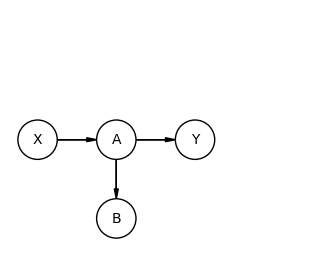

In [2]:
# @title # Game 1
# @markdown While this is a "trivial" example, many statisticians would consider including either or both A and B in their models "just for good measure".  Notice though how controlling for A would close off the path of causal information from X to Y, actually *impeding* your effort to measure that effect.
pgm = PGM(shape=[4, 3])

pgm.add_node(daft.Node("X", r"X", 1, 2))
pgm.add_node(daft.Node("Y", r"Y", 3, 2))
pgm.add_node(daft.Node("A", r"A", 2, 2))
pgm.add_node(daft.Node("B", r"B", 2, 1))


pgm.add_edge("X", "A")
pgm.add_edge("A", "Y")
pgm.add_edge("A", "B")

pgm.render()
plt.show()

There are no arrows leading into $X$, therefore not back-door paths.

#### Game 2

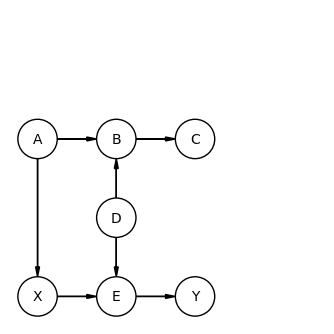

In [3]:
# @title # Game 2
# @markdown This graph looks harder, but actualy is also trivial to solve.  The key is noticing the one backdoor path, which goes from X <- A -> B <- D -> E -> Y, has a collider at B (or a 'V structure'), and therefore the backdoor path is closed.
pgm = PGM(shape=[4, 4])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 1, 3))
pgm.add_node(daft.Node("B", r"B", 2, 3))
pgm.add_node(daft.Node("C", r"C", 3, 3))
pgm.add_node(daft.Node("D", r"D", 2, 2))
pgm.add_node(daft.Node("E", r"E", 2, 1))


pgm.add_edge("X", "E")
pgm.add_edge("A", "X")
pgm.add_edge("A", "B")
pgm.add_edge("B", "C")
pgm.add_edge("D", "B")
pgm.add_edge("D", "E")
pgm.add_edge("E", "Y")

pgm.render()
plt.show()

In this example you should think of $A$, $B$, and $D$ as "pretreatment" variables. The treatment, as usual, is $X$. Now, there is one back-door path $X \leftarrow A \rightarrow B \leftarrow D \rightarrow E \rightarrow Y$. This path is already blocked by the collider at $B$, so we don't  need to control for anything. Many statisticians would control for $B$ or $C$, thinking there is no harm in doing so as long as they occur before the treatment. Conditioning on $B$ or $C$ is a poor idea because it would open the noncausal path and therefore confound $X$ and $Y$. We however could reclose the path by controlling for $A$ and $D$. There are different strategies for deconfounding. The easy way: not control for anything. Alternatively, you may control for $C$ and $D$.

#### Game 3

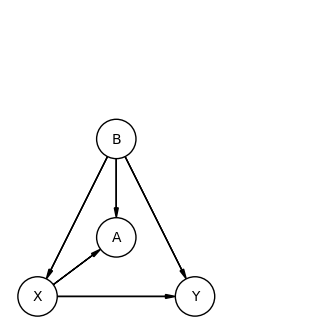

In [4]:
# @title # Game 3
# @markdown This game actually requires some action.  Notice the backdoor path X <- B -> Y.  This is a confounding pattern, is one of the clearest signs that we'll need to control for something, in this case B.
pgm = PGM(shape=[4, 4])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 2, 1.75))
pgm.add_node(daft.Node("B", r"B", 2, 3))


pgm.add_edge("X", "Y")
pgm.add_edge("X", "A")
pgm.add_edge("B", "A")
pgm.add_edge("B", "X")
pgm.add_edge("B", "Y")

pgm.render()
plt.show()

There is one back-door path from $X$ to $Y$, $X\leftarrow B\rightarrow Y$, which can only be blocked by controlling for $B$. If $B$ is unobserved, then there is no way of estimating the effect of $X$ on $Y$ without running a randomized controlled experiment. 

#### Game 4

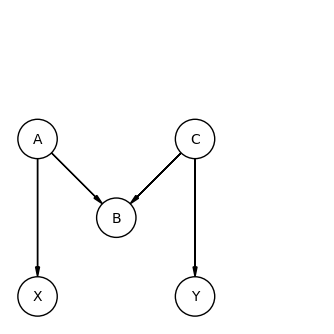

In [5]:
# @title # Game 4
# @markdown Pearl named this particular configuration "M Bias", not only because of it's shape, but also because of the common practice of statisticians to want to control for B in many situations.  However, notice how in this configuration X and Y start out as *not confounded* and how by controlling for B we would actually introduce confounding by opening the path at the collider, B.
pgm = PGM(shape=[4, 4])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 1, 3))
pgm.add_node(daft.Node("B", r"B", 2, 2))
pgm.add_node(daft.Node("C", r"C", 3, 3))


pgm.add_edge("A", "X")
pgm.add_edge("A", "B")
pgm.add_edge("C", "B")
pgm.add_edge("C", "Y")

pgm.render()
plt.show()

There is only one back-door path, and it is already blocked by a collider at $B$. 

_Example_: Seatbelt usage ($B$) has no causal effect on smoking ($X$) or lung diseasse ($Y$). It is merely an indicator of a person's  attitudes toward societal norms ($A$) as well as safety and health-related measures ($C$). Some of these attitudes may affect susceptibility to lung disease ($Y$). In practice, seatbelt usage was found to be correlated with both $X$ and $Y$. 

It is alright to control for $B$ if you also control for $A$ and $C$. Controlling for the collider $B$ however, opens the "pipe", but controlling for $A$ or $C$ closes it again. Unfortunately, the seat-belt example, $A$ and $C$ are variables relating to people's attitudes and not likely to be observable. If you can't observe it, you can't adjust for it. 

#### Game 5

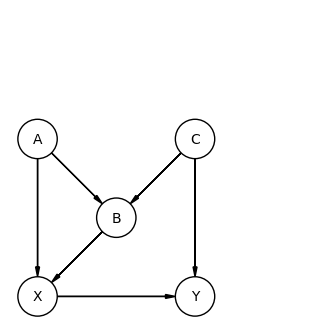

In [6]:
# @title # Game 5
# @markdown This is the last game in The Book of Why is the most complex.  In this case we have two backdoor paths, one going through A and the other through B, and it's important to notice that if we only control for B that the path: X <- A -> B <- C -> Y (which starts out as closed because B is a collider) actually is opened.  Therefore we have to either close both A and B or, as astute observers will notice, we can also just close C and completely close both backdoor paths.  pgmpy will nicely confirm these results for us.
pgm = PGM(shape=[4, 4])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 1, 3))
pgm.add_node(daft.Node("B", r"B", 2, 2))
pgm.add_node(daft.Node("C", r"C", 3, 3))


pgm.add_edge("A", "X")
pgm.add_edge("A", "B")
pgm.add_edge("C", "B")
pgm.add_edge("C", "Y")
pgm.add_edge("X", "Y")
pgm.add_edge("B", "X")

pgm.render()
plt.show()

Game 5 is just Game 4 with a little extra wrinkle. Now a second back-door path $X \leftarrow B \leftarrow C \rightarrow Y$ needs to be closed. If we close this path by controlling $B$, then we open up the $M$-shape path $X \leftarrow A \rightarrow B \leftarrow C \rightarrow Y$. To close that path, we must control for $A$ or $C$ as well. However, notice, that we could just control for $C$ alone. That would close the path $X \leftarrow B \leftarrow C \rightarrow Y$ and not affect other path. 

## Task 2 - Simpson's paradox

Imagine a doctor - Dr. Simpson, we'll call him - reading in his office about a promising new drug (Drug $D$) that seems to reduce the risk of a heart attack. Excitedly, he looks up the researcher's data online. His excitment cools a little when he looks at the data on male patients and notices that their risk of a heart attack is actually higher if they take Drug  $D$. "Oh well, he says, "Drug $D$ must be very effective for women." But then he turns to the next table, and his disappointment turns to bafflement. "What is this?" Dr. Simpson exclaims. "It says here that women who took Drug $D$ were also at higher risk of a heart attack. I must be losing my marbles! This drug seems to be bad for women, bad for men, but good for people."

| Gender | Control Group (No Drug) | Treatment Group (Took Drug) |
|--------|--------------------------|-----------------------------|
|        | Heart Attack | No Heart Attack | Heart Attack | No Heart Attack |
| Female |      1       |       28        |      3       |       37        |
| Male   |     12       |       28        |      8       |       12        |
| Total  |     13       |       47        |     11       |       49        |


**Task2a** Emphasize where the paradox is. 

5 percent (one in twenty) of the women in the control group later had a heart attack, compared to 7.5 percent of the women who took the drug. So the drug is associated with a higher risk of heart attack for women. Among the 30 percent in the control group had a heart attack, compared to 40 percent in the treatment group. So the drug is associated with a higher risk of heart attack among them. But now look at the third line of the table. Among the control group, 22 percent had a heart attack, but in the treatment group only 18 percent did. So, if we judge on the basis of the bottom line, Drug $D$ seems to decrease the risk of heart attack in the population as a whole. Welcome to the bizarre world of Simpson's paradox!

_Paradox_: A drug can't simultaneously cause me and you to have a heart attack and at the same time prevent us both from having heart attacks. 

**Task 2b** To understand the paradoxon, we must look beyond the data to the data-generating process. Discuss the paradoxon with a causal diagram.

The provided Bayesian Network models three variables:
- \( G \): Gender (`m` or `f`)
- \( D \): Drug (`0` or `1`)
- \( H \): Heart Attack (`0` or `1`)

The relationships are defined as:
- $ G \rightarrow D \rightarrow H$
- $ G \rightarrow H $

_Solution_: The causal diagram encodes the crucial information that gender is unaffected by the drug and, in addition, gender affects the risk of heart attack (men being at greater risk) and whether the patient chooses to take Drug $D$. In the study, women clearly had a preference for taking Drug $D$ and men preferred not to. Thus Gender is a confounder of Drug and Heart Attack. For an unbiased estimate of the effect of Drug on Heart Attack, we must adjust for the confounder. We can do that by looking at the data for men and women separately, then taking the average:

- For women, the rate of heart attacks was 5 percent without Drug $D$ and 7.5 percent with Drug $D$.

- For men, the rate of heart attacks was 30 percent without Drug $D$ and 40 percent with.

- Taking the average (because men and women are equally frequent in the general population), the rate of heart attacks without Drug $D$ is 17.5 percent (the average of 5 and 30), and the rate with Drug $D$ is 23.75 percent (the average of 7.5 and 40).

This is the clear and unambiguous answer we were looking for. Drug $D$ is bad for women, bad for men, and bad for people.

**Task 2c** Construct the Bayesian Network by means of `pgmpy`.

<Axes: >

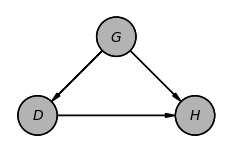

In [21]:
!pip install daft
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import CausalInference
simp_model = BayesianNetwork([("G", "D"), ("D", "H"), ("G", "H")])
simp_model.to_daft(node_pos={"D": (0, 0), "H": (2, 0), "G": (1, 1)}).render()

In [22]:
cpd_s = TabularCPD(
    variable="G", variable_card=2, values=[[0.5], [0.5]], state_names={"G": ["m", "f"]}
)
cpd_t = TabularCPD(
    variable="D",
    variable_card=2,
    values=[[0.66, 0.34], [0.34, 0.66]],
    evidence=["G"],
    evidence_card=[2],
    state_names={"G": ["m", "f"], "D": [0, 1]},
)
print(cpd_t)
cpd_c = TabularCPD(
    variable="H",
    variable_card=2,
    values=[[0.7, 0.6, 0.95, 0.925], [0.3, 0.4, 0.05, 0.075]],
    evidence=["G", "D"],
    evidence_card=[2, 2],
    state_names={"G": ["m", "f"], "D": [0, 1], "H": [0, 1]},
)
print(cpd_c)
simp_model.add_cpds(cpd_s, cpd_t, cpd_c)

+------+------+------+
| G    | G(m) | G(f) |
+------+------+------+
| D(0) | 0.66 | 0.34 |
+------+------+------+
| D(1) | 0.34 | 0.66 |
+------+------+------+
+------+------+------+------+-------+
| G    | G(m) | G(m) | G(f) | G(f)  |
+------+------+------+------+-------+
| D    | D(0) | D(1) | D(0) | D(1)  |
+------+------+------+------+-------+
| H(0) | 0.7  | 0.6  | 0.95 | 0.925 |
+------+------+------+------+-------+
| H(1) | 0.3  | 0.4  | 0.05 | 0.075 |
+------+------+------+------+-------+


**Task 2d** Compute the probability for a heart attack $H=1$ given treatment with drug by means of `pgmpy`.

In [28]:
# Non adjusted inference
infer_non_adjust = VariableElimination(simp_model)
print(infer_non_adjust.query(variables=["H"], evidence={"D": 1}))
print(infer_non_adjust.query(variables=["H"], evidence={"D": 0}))

+------+----------+
| H    |   phi(H) |
+======+==========+
| H(0) |   0.8145 |
+------+----------+
| H(1) |   0.1855 |
+------+----------+
+------+----------+
| H    |   phi(H) |
+======+==========+
| H(0) |   0.7850 |
+------+----------+
| H(1) |   0.2150 |
+------+----------+


The probability for a heart attack without drug is 18.5 percent. The probability for a heart attack with drug is 21.5 percent. 

**Task 2e** Compute the probability for a heart attack $H=1$ given treatment with do(drug) by means of `pgmpy`.

In [24]:
infer_adjusted = CausalInference(simp_model)
print(infer_adjusted.query(variables=["H"], do={"D": 1}))
print(infer_adjusted.query(variables=["H"], do={"D": 0}))

  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| H    |   phi(H) |
+======+==========+
| H(0) |   0.7625 |
+------+----------+
| H(1) |   0.2375 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| H    |   phi(H) |
+======+==========+
| H(0) |   0.8250 |
+------+----------+
| H(1) |   0.1750 |
+------+----------+


The probability for a heart attacks without drug is 17.5 percent. The probability for a heart attack with drug is 23.75 percent. 

**Task 2d** Compare and interpret the results of \( P(C | T = 1) \) and \( P(C | do(T = 1)) \). Discuss the importance of causal inference techniques in resolving paradoxes like Simpson's.

_Solution_: The do-operator corrects for confounding by adjusting for the confounder `Gender`. Applying the do-operator resolves Simpson's paradoxon.